In [27]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
DATASET = "/kaggle/input/2750-dataset/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


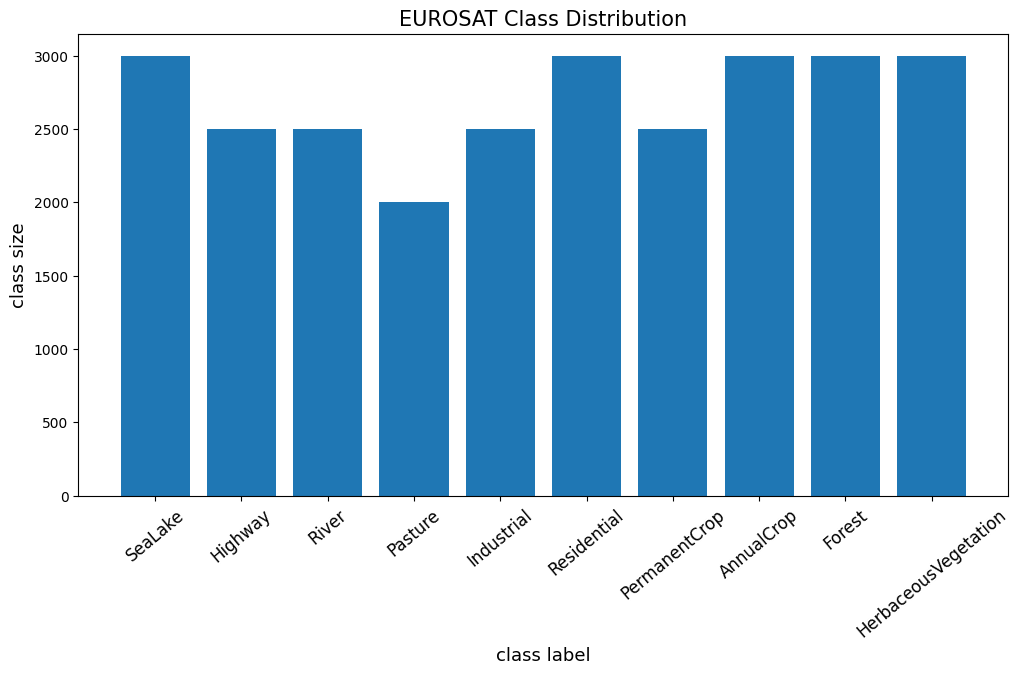

In [29]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [30]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [31]:
import os
import re
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DATASET = '/kaggle/input/2750-dataset/2750'
TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
LABELS = os.listdir(DATASET)  # Assuming each subdirectory in DATASET corresponds to a class

# Map each image path to its class label in 'data'
data = {}
for l in LABELS:
    for img in os.listdir(os.path.join(DATASET, l)):
        data[os.path.join(DATASET, l, img)] = l

# Convert the mapping to pandas Series
X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

# Perform stratified split
train_paths, test_paths, _, _ = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

# Define new paths for training and testing
new_train_paths = [re.sub(DATASET, TRAIN_DIR, path) for path in train_paths]
new_test_paths = [re.sub(DATASET, TEST_DIR, path) for path in test_paths]

# Move files to training directory
print("Moving training files...")
for source, destination in tqdm(zip(train_paths, new_train_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

# Move files to testing directory
print("Moving testing files...")
for source, destination in tqdm(zip(test_paths, new_test_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

Moving training files...


21600it [02:32, 142.05it/s]


Moving testing files...


5400it [00:38, 139.75it/s]


In [32]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)


Found 21704 images belonging to 10 classes.
Found 5500 images belonging to 10 classes.


In [33]:
print(train_generator.class_indices)


{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [34]:
np.save('class_indices', train_generator.class_indices)


In [35]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet101
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [36]:
from keras.models import Sequential, Model
from keras.applications import ResNet101
from keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score
import numpy as np


def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [58]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 2

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.best.keras',
                              monitor='val_categorical_accuracy',
                              save_best_only=True,
                              verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [59]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='gelu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='gelu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='gelu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='gelu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='gelu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(n_classes, activation='softmax'))  # Assuming softmax for classification

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model


from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import DenseNet121
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout


def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    if cnn_base == 'ResNet101':
        conv_base = ResNet101(include_top=False,
                              weights=None,  # Load weights manually
                              input_shape=input_shape)
        #conv_base.load_weights('/kaggle/input/weights2/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5')  # Load weights from local file
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        output_layer = Dense(n_classes, activation='softmax')(top_model)
        model = Model(inputs=conv_base.input, outputs=output_layer)
    elif cnn_base=='ResNet50':
        conv_base = ResNet50(include_top=False,
                             weights=None, 
                             input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        output_layer = Dense(n_classes, activation='softmax')(top_model)
        model = Model(inputs=conv_base.input, outputs=output_layer)
    elif cnn_base == 'VGG16':
        conv_base = VGG16(include_top=False,
                          weights=None, 
                          input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        output_layer = Dense(n_classes, activation='softmax')(top_model)
        model = Model(inputs=conv_base.input, outputs=output_layer)
    elif cnn_base == 'DenseNet121':
        conv_base = DenseNet121(include_top=False,
                                weights=None,  # Change to None since we'll load weights manually
                                input_shape=input_shape)
        #conv_base.load_weights('/kaggle/input/weigths/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation=tf.keras.activations.gelu)(top_model)
        top_model = Dropout(0.2)(top_model)
        output_layer = Dense(n_classes, activation='softmax')(top_model)
        model = Model(inputs=conv_base.input, outputs=output_layer)
    elif cnn_base=='googlenet':
        model = Sequential([
            # Input block
            tf.keras.layers.InputLayer(input_shape=input_shape),
            Flatten(),
            Dense(128),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            # Hidden block
            Dense(128),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            # Output block
            Dense(n_classes),
            BatchNormalization(),
            tf.keras.layers.Activation('softmax'),
        ])
    elif cnn_base=='geosystemnet':
        model = Sequential([
            # Input block
            tf.keras.layers.InputLayer(input_shape=input_shape),
            Flatten(),
            Dense(128),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            # Hidden block
            Dense(128),
            BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            Dropout(0.5),

            # Output block
            Dense(n_classes),
            BatchNormalization(),
            tf.keras.layers.Activation('softmax'),
        ])
    
    elif cnn_base=='shallow_cnn':
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, activation='softmax'))

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        raise ValueError("Unsupported CNN base architecture")    

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model



In [ ]:
resnet101_model = compile_model(INPUT_SHAPE, NUM_CLASSES,Adam(learning_rate=1e-3, amsgrad=False, epsilon=1e-6, name='lamb'), fine_tune=None)
resnet101_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,082,922 (4.13 MB)

 Trainable params: 1,082,922 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 20

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.best.keras',
                              monitor='val_categorical_accuracy',
                              save_best_only=True,
                              verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [71]:
"""resnet101_model = resnet101_model.fit(train_generator,
                                      steps_per_epoch=N_STEPS,
                                      epochs=1,
                                      callbacks=[early_stop, checkpoint],
                                      validation_data=test_generator,
                                      validation_steps=N_VAL_STEPS)"""

'resnet101_model = resnet101_model.fit(train_generator,\n                                      steps_per_epoch=N_STEPS,\n                                      epochs=1,\n                                      callbacks=[early_stop, checkpoint],\n                                      validation_data=test_generator,\n                                      validation_steps=N_VAL_STEPS)'

In [72]:
# re-train whole network end2end 
resnet101_model = compile_model(INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)

#resnet101_model.load_weights('../working/model.best.keras')

train_generator.reset()
test_generator.reset()

resnet101_history = resnet101_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=70,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/70
  3/339 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - categorical_accuracy: 0.1363 - loss: 12.2276

W0000 00:00:1713100198.652971     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/339 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - categorical_accuracy: 0.0925 - loss: 320.9647

W0000 00:00:1713100207.173630     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/339 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_accuracy: 0.0970 - loss: 123.9463

W0000 00:00:1713100236.237011     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


339/339 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - categorical_accuracy: 0.0970 - loss: 123.4391 - val_categorical_accuracy: 0.0943 - val_loss: 2.4438
Epoch 2/70
  1/339 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - categorical_accuracy: 0.0781 - loss: 2.4024

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.0781 - loss: 2.4024 - val_categorical_accuracy: 1.0000 - val_loss: 1.8381
Epoch 3/70


W0000 00:00:1713100238.705709     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


339/339 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - categorical_accuracy: 0.1040 - loss: 2.3917 - val_categorical_accuracy: 0.1248 - val_loss: 2.3199
Epoch 4/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - categorical_accuracy: 0.1562 - loss: 2.3186 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.3813
Epoch 5/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - categorical_accuracy: 0.0990 - loss: 2.3683 - val_categorical_accuracy: 0.0401 - val_loss: 2.3388
Epoch 6/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - categorical_accuracy: 0.0000e+00 - loss: 2.3807 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.3839
Epoch 7/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - categorical_accuracy: 0.0996 - loss: 2.3710 - val_categorical_accuracy: 0.0939 - val_loss: 2.3191
Epoch 8/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - categorical_accuracy: 0.0938 - loss: 2.3538 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.2078
Epoch 9/70
339/339 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - categorical_ac

In [75]:
plot_history(resnet101_history)

TypeError: 'History' object is not subscriptable

In [76]:
from keras.models import load_model

# Load the entire model (architecture and weights)
resnet101_history = load_model('../working/model.best.keras')

# Print the summary of the loaded model to check its architecture
#resnet101_history.summary()

class_indices = train_generator.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

# Use the predict method directly instead of predict_generator
predictions = resnet101_history.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf


Found 5500 images belonging to 10 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Accuracy: 0.6716363636363636
Global F2 Score: 0.6716363636363636


,Precision,Recall,F-Score,Support
AnnualCrop,0.329261,0.886513,0.480178,608.0
Forest,0.958106,0.863711,0.908463,609.0
HerbaceousVegetation,0.807471,0.462171,0.587866,608.0
Highway,0.498507,0.327451,0.395266,510.0
Industrial,0.912682,0.855750,0.883300,513.0
Pasture,0.765182,0.459854,0.574468,411.0
PermanentCrop,0.633721,0.425781,0.509346,512.0
Residential,0.817558,0.977049,0.890217,610.0
River,0.714789,0.397260,0.510692,511.0
SeaLake,0.981685,0.881579,0.928943,608.0
